# ESG Pre-filter Classifier - Model Evaluation & Deployment

## Project Context

This notebook is part of an **ESG News Monitoring System** that tracks sustainability trends for 50 sportswear and outdoor apparel brands. The ESG Pre-filter (EP) classifier is the **second filter in the pipeline**, identifying articles with ESG/sustainability content before detailed LLM classification.

**Pipeline Position:** Data Collection → FP Filter → **EP Filter (this classifier)** → LLM Labeling

---

## Notebook Objective

This is the **final evaluation notebook** for the EP classifier. It performs:

1. **Test set evaluation** - Unbiased performance assessment on held-out data
2. **Threshold optimization** - Find optimal decision boundary for target recall
3. **Deployment export** - Package model artifacts for production API
4. **Model explainability** - LIME, SHAP feature groups, and prototype explanations

**Important:** This is the ONLY notebook that uses the test set. All model selection and tuning was performed in ep2 using cross-validation.

---

## Technical Approach

### Evaluation Methodology
- **Generalization Check:** Compare CV metrics from ep2 against test set performance
- **Metrics:** F2 score (primary), recall, precision, accuracy, PR-AUC, confusion matrix
- **Gap Analysis:** Flag significant degradation (>5%) between CV and test performance

### Threshold Optimization
- **Target Recall:** 99% (prioritize catching all ESG content)
- **Trade-off Analysis:** Precision-recall curves at multiple target recall levels
- **Business Logic:** Lower threshold = higher recall, more non-ESG articles pass to LLM

### Deployment Artifacts
| Artifact | Description |
|----------|-------------|
| `ep_classifier_pipeline.joblib` | Complete sklearn Pipeline (transformer + classifier) |
| `ep_classifier_config.json` | Threshold, metrics, hyperparameters for API configuration |

### Pipeline Validation
- Test on realistic articles with known ESG/non-ESG labels
- Verify edge cases: financial reports, product launches, sponsorship deals
- Confirm probability calibration for threshold-based decisions

### Model Explainability

Three complementary approaches to interpret predictions from text classifiers with abstract features (TF-IDF/LSA, embeddings, product/sponsor features):

| Method | What It Shows | Use Case |
|--------|---------------|----------|
| **SHAP Feature Groups** | Which feature types matter most (LSA semantic features, product/sponsor detection) | Understanding model behavior at a high level |
| **LIME Word-Level** | Specific words that influenced individual predictions (ESG keywords vs product terms) | Debugging specific predictions, stakeholder explanations |
| **Prototype Explanations** | Similar training examples ("this article is like these known ESG/non-ESG examples") | Building intuition, catching label errors |

**Production Integration Options:**
- `/predict?explain=lime` - Word-level explanations
- `/predict?explain=prototype` - Similar example lookup
- `/model/explain` - Feature group importance summary

---

## Contents

1. [Setup](#setup)
2. [Data Loading & Split](#1-data-loading--split)
3. [Load Artifacts from ep1/ep2](#2-load-artifacts-from-ep1ep2)
4. [Test Set Evaluation](#3-test-set-evaluation)
5. [Threshold Optimization](#4-threshold-optimization)
6. [Model Explainability](#5-model-explainability)
7. [Export for Deployment](#6-export-for-deployment)
8. [Pipeline Validation](#7-pipeline-validation)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sklearn imports
from sklearn.metrics import fbeta_score

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.ep1_nb.data_utils import load_jsonl_data, split_train_val_test
from src.ep1_nb.preprocessing import clean_text, create_text_features
from src.ep1_nb.modeling import evaluate_model
from src.ep3_nb.threshold_optimization import (
    find_optimal_threshold,
    analyze_threshold_tradeoffs,
    plot_threshold_analysis,
)
from src.ep3_nb.deployment import (
    create_deployment_pipeline,
    save_deployment_artifacts,
    validate_pipeline_with_articles,
)

# Explainability imports
from src.ep3_nb import (
    TextExplainer,
    get_ep_feature_groups,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TARGET_COL = 'has_esg'
LABEL_NAMES = ['No ESG', 'Has ESG']
TARGET_RECALL = 0.99  # Target recall for threshold optimization

# Paths
DATA_PATH = project_root / 'data' / 'ep_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

print("Setup complete!")

Setup complete!


## 1. Data Loading & Split

Load data and apply identical preprocessing and split as ep1/ep2 to ensure consistency.

In [2]:
# Load the EP training data (same as ep1/ep2)
df = load_jsonl_data(DATA_PATH)

# Create combined text features (identical to ep1/ep2)
# Includes metadata (source_name, category) for consistency
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print(f"\nText features created!")

Loaded 957 records from ep_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'has_esg', 'source', 'skip_reason']
Memory usage: 6.64 MB

Text features created!


In [3]:
# Split with stratification (identical to ep1/ep2 - same random_state ensures identical splits)
train_df, val_df, test_df = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=RANDOM_STATE
)

# Extract metadata for discrete metadata features (same as ep1/ep2)
test_source_names = test_df['source_name'].tolist()
test_categories = test_df['category'].tolist()

TRAIN/VALIDATION/TEST SPLIT

Total samples: 957

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      573 (59.9%)
  Validation: 192 (20.1%)
  Test:       192 (20.1%)

Class distribution (stratified by 'has_esg'):
  Train: 0: 55.5%, 1: 44.5%
  Val: 0: 55.2%, 1: 44.8%
  Test: 0: 55.7%, 1: 44.3%


## 2. Load Artifacts from ep1/ep2

Load the feature transformer from ep1 and the best classifier from ep2.

In [4]:
# Load feature transformer from ep1
transformer_path = MODELS_DIR / 'ep_feature_transformer.joblib'
transformer = joblib.load(transformer_path)
print(f"Loaded transformer: {transformer}")

# Load best classifier from ep2
classifier_path = MODELS_DIR / 'ep_best_classifier.joblib'
best_model = joblib.load(classifier_path)
print(f"Loaded classifier: {type(best_model).__name__}")

# Load CV metrics from ep2
cv_metrics_path = MODELS_DIR / 'ep_cv_metrics.json'
with open(cv_metrics_path) as f:
    cv_metrics = json.load(f)

print(f"\nCV Metrics (from ep2):")
print(f"  Model: {cv_metrics['model_name']}")
print(f"  CV F2: {cv_metrics['cv_f2']:.4f}")
print(f"  CV Recall: {cv_metrics['cv_recall']:.4f}")
print(f"  CV Precision: {cv_metrics['cv_precision']:.4f}")

Loaded transformer: EPFeatureTransformer(method='tfidf_lsa_product', max_features=10000, fitted=True)
Loaded classifier: RandomForestClassifier

CV Metrics (from ep2):
  Model: RF_tuned
  CV F2: 0.8515
  CV Recall: 0.8594
  CV Precision: 0.8247


In [5]:
# Transform test set using the fitted transformer
# Pass metadata for discrete metadata features (consistent with ep1/ep2)
X_test = transformer.transform(
    test_df['text_features'],
    source_names=test_source_names,
    categories=test_categories
)
y_test = test_df[TARGET_COL].values

print(f"X_test shape: {X_test.shape}")
print(f"y_test distribution: {pd.Series(y_test).value_counts().to_dict()}")

X_test shape: (192, 152)
y_test distribution: {0: 107, 1: 85}


## 3. Test Set Evaluation

Evaluate the best model on the held-out test set (used only once, here).


MODEL EVALUATION: RF_tuned on Test

Classification Metrics:
  Accuracy:  0.8750
  Precision: 0.8427
  Recall:    0.8824
  F1 Score:  0.8621
  ROC-AUC:   0.9421
  PR-AUC:    0.9225

Confusion Matrix:
  TN: 93  FP: 14
  FN: 10  TP: 75

              precision    recall  f1-score   support

      No ESG       0.90      0.87      0.89       107
     Has ESG       0.84      0.88      0.86        85

    accuracy                           0.88       192
   macro avg       0.87      0.88      0.87       192
weighted avg       0.88      0.88      0.88       192

Figure saved to images/ep_test_evaluation.png


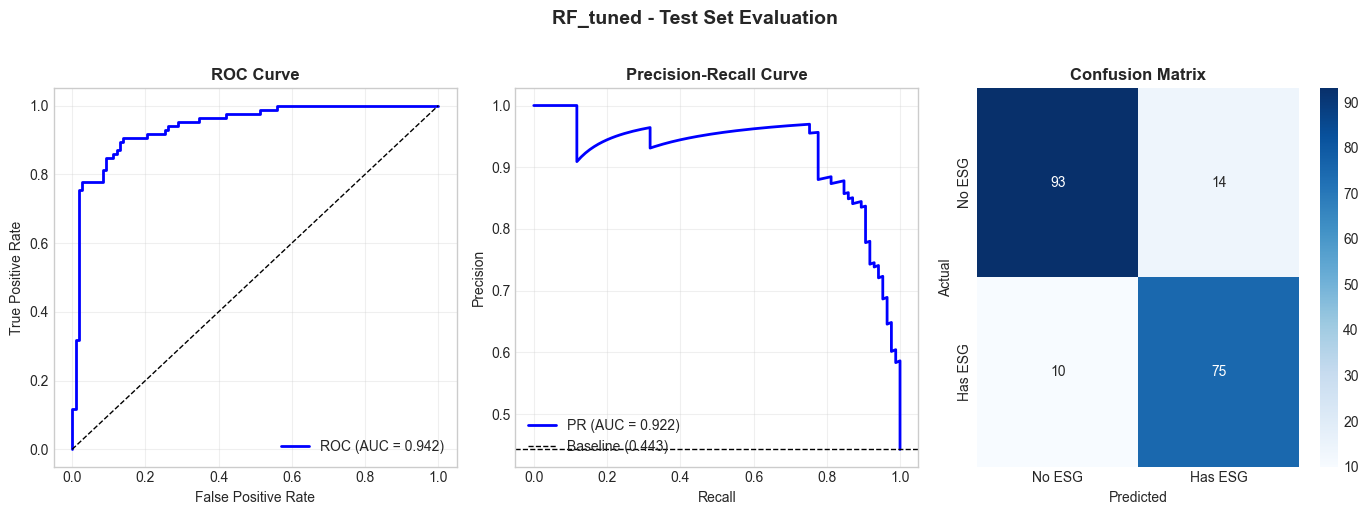

  F2 Score:  0.8741 (recall-weighted)


In [6]:
# Evaluate on held-out test set
test_metrics = evaluate_model(
    best_model, X_test, y_test,
    model_name=cv_metrics['model_name'],
    dataset_name='Test',
    verbose=True,
    plot=True,
    save_path='images/ep_test_evaluation.png'
)

# Add F2 score
y_pred_test = best_model.predict(X_test)
test_metrics['f2'] = fbeta_score(y_test, y_pred_test, beta=2)
print(f"  F2 Score:  {test_metrics['f2']:.4f} (recall-weighted)")

In [7]:
# Compare CV vs Test performance (generalization check)
print("=" * 60)
print("GENERALIZATION CHECK: CV vs Test Performance")
print("=" * 60)
print(f"\n{'Metric':<15} {'CV':>10} {'Test':>10} {'Gap':>10}")
print("-" * 45)

metrics_to_compare = ['f2', 'recall', 'precision']
for metric in metrics_to_compare:
    cv_val = cv_metrics[f'cv_{metric}']
    test_val = test_metrics[metric]
    gap = test_val - cv_val
    status = "OK" if abs(gap) < 0.05 else "WATCH"
    print(f"{metric.upper():<15} {cv_val:>10.4f} {test_val:>10.4f} {gap:>+10.4f}  [{status}]")

print("-" * 45)
print("\nNote: Small gaps (< 0.05) indicate good generalization.")
print("=" * 60)

GENERALIZATION CHECK: CV vs Test Performance

Metric                  CV       Test        Gap
---------------------------------------------
F2                  0.8515     0.8741    +0.0226  [OK]
RECALL              0.8594     0.8824    +0.0230  [OK]
PRECISION           0.8247     0.8427    +0.0180  [OK]
---------------------------------------------

Note: Small gaps (< 0.05) indicate good generalization.


## 4. Threshold Optimization

Analyze precision-recall trade-offs at different thresholds and select optimal threshold for target recall.

In [8]:
# Get predicted probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Analyze threshold tradeoffs
threshold_df = analyze_threshold_tradeoffs(
    y_test, y_proba,
    target_recalls=[0.90, 0.95, 0.97, 0.98, 0.99],
    verbose=True
)

THRESHOLD ANALYSIS: Recall vs Precision Trade-off

Total positives: 85, Total negatives: 107

--------------------------------------------------------------------------------
  Target | Threshold |   Recall | Precision |     F2 |    FPs |    FNs
--------------------------------------------------------------------------------
    90% |    0.4629 |   90.6% |    83.7% | 0.8912 |     15 |      8
    95% |    0.2711 |   95.3% |    72.3% | 0.8960 |     31 |      4
    97% |    0.2134 |   97.6% |    64.8% | 0.8868 |     45 |      2
    98% |    0.1657 |   98.8% |    60.4% | 0.8768 |     55 |      1
    99% |    0.1367 |  100.0% |    58.6% | 0.8763 |     60 |      0
--------------------------------------------------------------------------------

Lower threshold = Higher recall but more FPs pass to downstream processing


In [9]:
# Find optimal threshold for target recall
optimal_threshold, threshold_metrics = find_optimal_threshold(
    y_test, y_proba,
    target_recall=TARGET_RECALL
)

print("=" * 60)
print("OPTIMAL THRESHOLD FOR DEPLOYMENT")
print("=" * 60)
print(f"\nTarget recall: {TARGET_RECALL:.0%}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"\nMetrics at optimal threshold:")
print(f"  Actual Recall:    {threshold_metrics['actual_recall']:.4f}")
print(f"  Precision:        {threshold_metrics['precision']:.4f}")
print(f"  F2 Score:         {threshold_metrics['f2_score']:.4f}")
print(f"  True Positives:   {threshold_metrics['true_positives']}")
print(f"  False Positives:  {threshold_metrics['false_positives']} (non-ESG passed to LLM)")
print(f"  False Negatives:  {threshold_metrics['false_negatives']} (ESG content missed)")
print("=" * 60)

OPTIMAL THRESHOLD FOR DEPLOYMENT

Target recall: 99%
Optimal threshold: 0.1367

Metrics at optimal threshold:
  Actual Recall:    1.0000
  Precision:        0.5862
  F2 Score:         0.8763
  True Positives:   85
  False Positives:  60 (non-ESG passed to LLM)
  False Negatives:  0 (ESG content missed)


Figure saved to images/ep_threshold_tradeoff.png


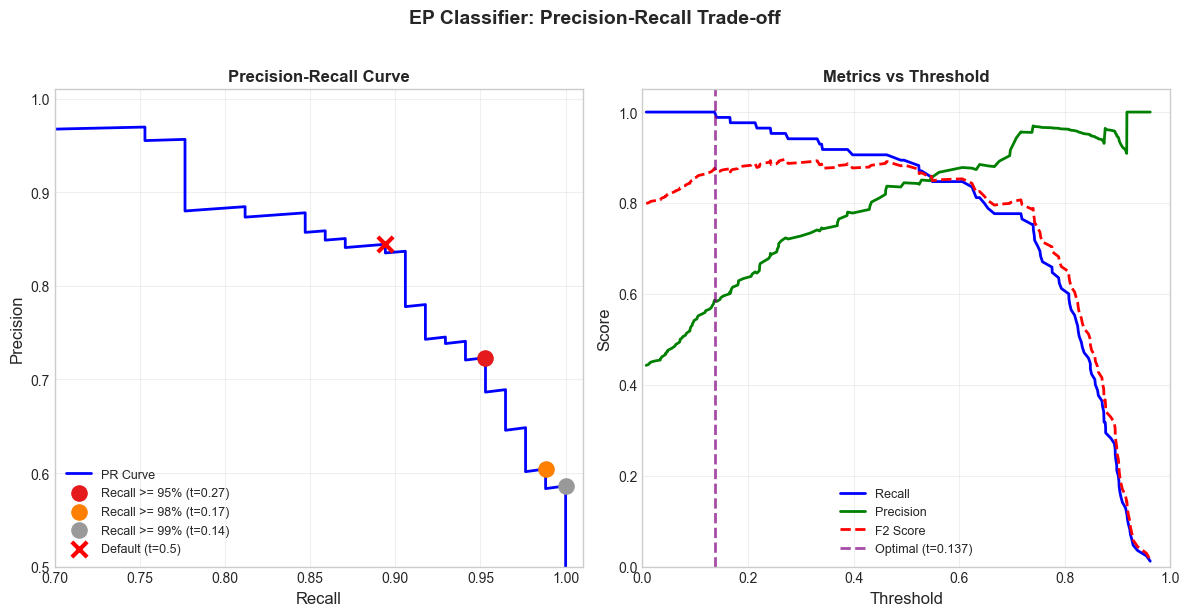

In [10]:
# Plot threshold analysis
fig = plot_threshold_analysis(
    y_test, y_proba,
    target_recalls=[0.95, 0.98, 0.99],
    optimal_threshold=optimal_threshold,
    title='EP Classifier: Precision-Recall Trade-off',
    save_path='images/ep_threshold_tradeoff.png'
)

## 5. Model Explainability

Understand what drives model predictions using three complementary approaches:
1. **LIME**: Word-level importance for individual predictions
2. **SHAP Feature Groups**: Aggregate importance by feature type
3. **Prototype Explanations**: Similar training examples

In [11]:
# Get feature groups for the EP classifier's feature method
feature_groups = get_ep_feature_groups(transformer.method)
print(f"Feature method: {transformer.method}")

# EP classifier uses tfidf_lsa_product which has LSA + product detection features
if not feature_groups:
    # tfidf_lsa_product: LSA (120) + product_sponsor features
    n_features = X_test.shape[1]
    lsa_components = transformer.lsa_n_components if hasattr(transformer, 'lsa_n_components') else 120
    feature_groups = {
        'lsa_features': range(0, lsa_components),
        'product_sponsor_features': range(lsa_components, n_features),
    }

print(f"\nFeature groups ({sum(len(list(v)) for v in feature_groups.values())} features):")
for name, indices in feature_groups.items():
    print(f"  {name}: {len(list(indices))} features (indices {min(indices)}-{max(indices)})")

# Define example articles for explainability analysis
example_articles = {
    "esg_content": {
        "title": "Nike Announces 50% Carbon Emissions Reduction Target",
        "content": "Nike Inc. unveiled ambitious sustainability goals at their annual investor conference. The athletic footwear giant plans to reduce carbon emissions by 50% across their global manufacturing operations by 2030. CEO John Donahoe emphasized the company's commitment to environmental responsibility, detailing investments in renewable energy at all owned facilities. The Move to Zero initiative includes recycling programs and sustainable materials research.",
        "brands": ["Nike"],
        "source_name": "Reuters",
        "category": ["business", "environment"],
    },
    "non_esg": {
        "title": "Nike Releases New Air Jordan Retro Collection for Holiday Season",
        "content": "Nike announced the release of a highly anticipated Air Jordan Retro collection just in time for the holiday shopping season. The collection features classic colorways from the 1990s alongside new designs. Basketball fans and sneaker collectors have been lining up at stores nationwide. The limited edition release is expected to sell out within hours of launch.",
        "brands": ["Nike"],
        "source_name": "ESPN",
        "category": ["sports", "lifestyle"],
    }
}

# Prepare text for LIME analysis
esg_article = example_articles["esg_content"]
esg_text = esg_article['title'] + ' ' + esg_article['content']

non_esg_article = example_articles["non_esg"]
non_esg_text = non_esg_article['title'] + ' ' + non_esg_article['content']

print("\nExample articles prepared for explainability analysis.")

Feature method: tfidf_lsa_product

Feature groups (152 features):
  lsa_features: 120 features (indices 0-119)
  product_sponsor_features: 32 features (indices 120-151)

Example articles prepared for explainability analysis.


### 5.1 SHAP Feature Group Importance

Aggregate SHAP values by feature group to understand which types of features drive predictions most.

In [12]:
# Initialize explainer with feature groups
explainer = TextExplainer(
    pipeline=best_model,
    feature_groups=feature_groups,
    class_names=["no_esg", "has_esg"],
    threshold=optimal_threshold,
)

# Compute feature group importance using SHAP
print("Computing SHAP feature group importance...")
print("(This may take a minute for tree models)")

shap_importance = explainer.explain_feature_groups(
    X_test,
    sample_size=100,  # Use subset for speed
    use_tree_explainer=True,  # Faster for RandomForest
)

# Display results
print("\n" + "=" * 60)
print("FEATURE GROUP IMPORTANCE (SHAP)")
print("=" * 60)
print(f"\n{'Feature Group':<25} {'Mean |SHAP|':>15} {'Contribution':>15}")
print("-" * 55)
for group, importance in shap_importance.top_groups:
    contribution = shap_importance.group_contribution[group]
    print(f"{group:<25} {importance:>15.4f} {contribution:>14.1%}")
print("-" * 55)

Computing SHAP feature group importance...
(This may take a minute for tree models)

FEATURE GROUP IMPORTANCE (SHAP)

Feature Group                 Mean |SHAP|    Contribution
-------------------------------------------------------
product_sponsor_features           0.0055          65.7%
lsa_features                       0.0029          34.3%
-------------------------------------------------------


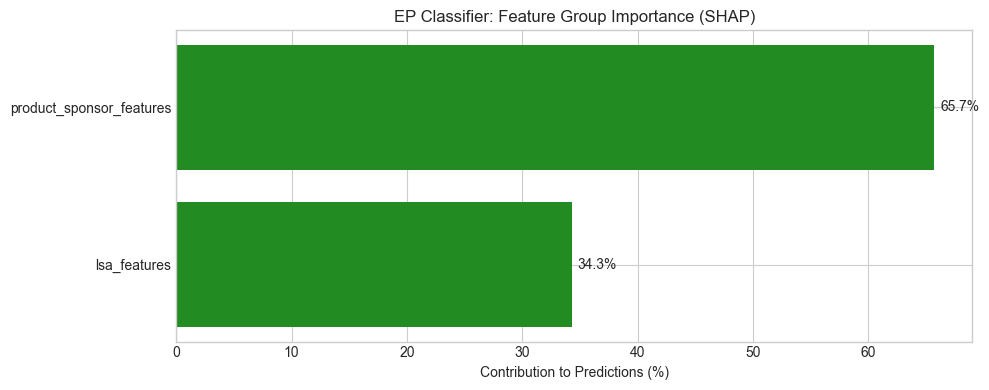


Interpretation:
- LSA features capture the semantic content of articles (ESG topics)
- Product/sponsor features help identify non-ESG business content


In [13]:
# Visualize feature group contributions
fig, ax = plt.subplots(figsize=(10, 4))

groups = list(shap_importance.group_contribution.keys())
contributions = [shap_importance.group_contribution[g] * 100 for g in groups]

bars = ax.barh(groups, contributions, color='forestgreen')
ax.set_xlabel('Contribution to Predictions (%)')
ax.set_title('EP Classifier: Feature Group Importance (SHAP)')

# Add value labels
for bar, val in zip(bars, contributions):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('images/ep_feature_group_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- LSA features capture the semantic content of articles (ESG topics)")
print("- Product/sponsor features help identify non-ESG business content")

### 5.2 LIME Word-Level Explanations

LIME perturbs input text and observes prediction changes to identify influential words.

In [14]:
# LIME explanation for ESG content article
print("=" * 60)
print("LIME EXPLANATION: ESG Content Article")
print("=" * 60)

lime_esg = explainer.explain_lime(
    text=esg_text,
    transformer=transformer,
    source_name=esg_article['source_name'],
    categories=esg_article['category'],
    num_features=10,
)

print(f"\nPrediction: {lime_esg.prediction} ({lime_esg.probability:.1%})")
print(f"\nTop influential words:")
print("-" * 40)
for word, weight in lime_esg.top_words:
    direction = "→ has_esg" if weight > 0 else "→ no_esg"
    print(f"  {word:20s} {weight:+.4f} {direction}")
print("-" * 40)
print(f"\n{lime_esg._generate_text_explanation()}")

LIME EXPLANATION: ESG Content Article

Prediction: has_esg (66.5%)

Top influential words:
----------------------------------------
  CEO                  +0.0213 → has_esg
  commitment           +0.0153 → has_esg
  responsibility       +0.0145 → has_esg
  global               +0.0129 → has_esg
  programs             +0.0127 → has_esg
  Nike                 +0.0122 → has_esg
  goals                +0.0108 → has_esg
  company              +0.0102 → has_esg
  research             -0.0082 → no_esg
  owned                -0.0055 → no_esg
----------------------------------------

Classified as has_esg (66.5% confidence). Key words supporting this: CEO, commitment, responsibility. Words suggesting otherwise: research, owned.


In [15]:
# LIME explanation for non-ESG article
print("=" * 60)
print("LIME EXPLANATION: Non-ESG Article (Product launch)")
print("=" * 60)

lime_non_esg = explainer.explain_lime(
    text=non_esg_text,
    transformer=transformer,
    source_name=non_esg_article['source_name'],
    categories=non_esg_article['category'],
    num_features=10,
)

print(f"\nPrediction: {lime_non_esg.prediction} ({lime_non_esg.probability:.1%})")
print(f"\nTop influential words:")
print("-" * 40)
for word, weight in lime_non_esg.top_words:
    direction = "→ has_esg" if weight > 0 else "→ no_esg"
    print(f"  {word:20s} {weight:+.4f} {direction}")
print("-" * 40)
print(f"\n{lime_non_esg._generate_text_explanation()}")
print("\nNote: Words like 'release', 'collection', 'limited', 'sneaker' push toward no_esg,")
print("while ESG-related words like 'sustainability', 'emissions' would push toward has_esg.")

LIME EXPLANATION: Non-ESG Article (Product launch)

Prediction: no_esg (90.7%)

Top influential words:
----------------------------------------
  colorways            -0.0503 → no_esg
  sneaker              -0.0402 → no_esg
  release              -0.0244 → no_esg
  Releases             -0.0212 → no_esg
  Holiday              -0.0176 → no_esg
  Nike                 +0.0169 → has_esg
  Air                  +0.0153 → has_esg
  limited              -0.0146 → no_esg
  Jordan               +0.0065 → has_esg
  collection           +0.0064 → has_esg
----------------------------------------

Classified as no_esg (90.7% confidence). Key words supporting this: Nike, Air, Jordan. Words suggesting otherwise: colorways, sneaker, release.

Note: Words like 'release', 'collection', 'limited', 'sneaker' push toward no_esg,
while ESG-related words like 'sustainability', 'emissions' would push toward has_esg.


### 5.3 Prototype-Based Explanations

Find similar training examples to explain predictions through analogy.

In [16]:
# Transform training data for prototype explanations
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()

X_train = transformer.transform(
    train_df['text_features'],
    source_names=train_source_names,
    categories=train_categories,
)
y_train = train_df[TARGET_COL].values

print(f"Training data prepared: {X_train.shape}")

# Fit prototype explainer using nearest neighbor search
explainer.fit_prototype_explainer(X_train, metric='cosine')
print("Prototype explainer fitted!")

Training data prepared: (573, 152)
Prototype explainer fitted!


In [17]:
# Prototype explanation for the ESG content article
print("=" * 80)
print("PROTOTYPE EXPLANATION: ESG Content Article")
print("=" * 80)
print("""
How prototype explanations work:
- Find training examples most similar to the query article (in feature space)
- Show their labels to provide intuition about the prediction
- If similar examples share the same label, it supports the model's prediction
""")

proto_esg = explainer.explain_prototype(
    text=esg_text,
    train_df=train_df,
    transformer=transformer,
    source_name=esg_article['source_name'],
    categories=esg_article['category'],
    n_neighbors=5,
    title_col='title',
    label_col='has_esg',
    text_col='text_features',
)

print(f"Query article: {esg_article['title'][:60]}...")
print(f"Model prediction: {proto_esg.prediction} ({proto_esg.probability:.1%})")
print(f"\nMost similar training examples (by cosine similarity in feature space):")
print("-" * 80)
for i, example in enumerate(proto_esg.similar_examples, 1):
    label_str = "HAS ESG" if example['label'] == 'has_esg' else "NO ESG"
    print(f"\n{i}. [{label_str}] Similarity: {example['similarity']:.3f}")
    print(f"   Title: {example['title'][:75]}")
print("-" * 80)

# Analyze label distribution for interpretation
similar_labels = [ex['label'] for ex in proto_esg.similar_examples]
esg_count = sum(1 for l in similar_labels if l == 'has_esg')
no_esg_count = len(similar_labels) - esg_count

print(f"\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print(f"""
Label distribution among 5 nearest neighbors:
  - Has ESG: {esg_count}/5
  - No ESG: {no_esg_count}/5
""")

if esg_count == len(similar_labels):
    print("""What this means:
ALL 5 most similar training examples contain ESG content. This strongly
supports the model's prediction. The query article about carbon emissions
reduction is most similar to other ESG-related training articles.

This is a k-NN style explanation: "Predict has_esg because all similar
training articles also had ESG content."
""")
elif esg_count > no_esg_count:
    print(f"""What this means:
The majority ({esg_count}/5) of similar training examples have ESG content,
which supports the model's prediction. The {no_esg_count} non-ESG examples
show some semantic overlap with general business content.
""")
else:
    print(f"""What this means:
Interestingly, most similar examples ({no_esg_count}/5) have no ESG content,
yet the model predicted 'has_esg'. This suggests the LSA/product features
detected ESG-specific patterns not captured by nearest-neighbor similarity.
""")
print("=" * 80)

PROTOTYPE EXPLANATION: ESG Content Article

How prototype explanations work:
- Find training examples most similar to the query article (in feature space)
- Show their labels to provide intuition about the prediction
- If similar examples share the same label, it supports the model's prediction

Query article: Nike Announces 50% Carbon Emissions Reduction Target...
Model prediction: has_esg (66.5%)

Most similar training examples (by cosine similarity in feature space):
--------------------------------------------------------------------------------

1. [HAS ESG] Similarity: 0.785
   Title: Shuffle Board : Puma Loses Comms Exec , Esprit Leadership Moves

2. [NO ESG] Similarity: 0.744
   Title: Ibagwa Nike confers chieftaincy title on Igbo - Eze South chairman

3. [NO ESG] Similarity: 0.711
   Title: NVIDIA Hits Back at Claims That Google TPUs Could Overtake Its AI Stack , S

4. [HAS ESG] Similarity: 0.693
   Title: How climate - friendly is your fashion ? Report ranks world largest fas

## 6. Export for Deployment

Create and save the complete pipeline (transformer + classifier) for Docker API deployment.

In [18]:
# Create deployment pipeline
full_pipeline = create_deployment_pipeline(
    transformer=transformer,
    classifier=best_model,
    pipeline_name='ep_classifier'
)

print(f"Created pipeline: {full_pipeline}")

Created pipeline: Pipeline(steps=[('features',
                 EPFeatureTransformer(include_metadata_features=False, lsa_n_components=120, method='tfidf_lsa_product')),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=10, n_estimators=180,
                                        n_jobs=-1, random_state=42))])


In [19]:
# Prepare deployment configuration
deployment_config = {
    # Threshold settings
    'threshold': float(optimal_threshold),
    'target_recall': TARGET_RECALL,
    
    # Model info
    'model_name': cv_metrics['model_name'],
    'transformer_method': transformer.method,
    'best_params': cv_metrics['best_params'],
    
    # CV performance
    'cv_f2': cv_metrics['cv_f2'],
    'cv_recall': cv_metrics['cv_recall'],
    'cv_precision': cv_metrics['cv_precision'],
    
    # Test performance
    'test_f2': float(test_metrics['f2']),
    'test_recall': float(test_metrics['recall']),
    'test_precision': float(test_metrics['precision']),
    
    # Performance at threshold
    'threshold_recall': float(threshold_metrics['actual_recall']),
    'threshold_precision': float(threshold_metrics['precision']),
    'threshold_f2': float(threshold_metrics['f2_score']),
}

# Save deployment artifacts
saved_paths = save_deployment_artifacts(
    pipeline=full_pipeline,
    config=deployment_config,
    models_dir=MODELS_DIR,
    pipeline_name='ep_classifier'
)

Pipeline saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_classifier_pipeline.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_classifier_config.json


## 7. Pipeline Validation

Test the exported pipeline on sample texts to ensure it works correctly.

In [20]:
# Define realistic validation articles with full metadata
# Each article includes title, content, brands, source_name, category, and expected_label
#
# These examples are designed to test edge cases:
# - True positives: Articles with clear ESG content (sustainability, labor, governance)
# - True negatives: Sportswear brand articles without ESG content (product launches, financial results)

validation_articles = [
    # ===== ARTICLES WITH ESG CONTENT (expected_label=1) =====
    {
        "title": "Nike Announces 50% Carbon Emissions Reduction Target",
        "content": "Nike Inc. unveiled ambitious sustainability goals at their annual investor conference. The athletic footwear giant plans to reduce carbon emissions by 50% across their global manufacturing operations by 2030. CEO John Donahoe emphasized the company's commitment to environmental responsibility, detailing investments in renewable energy at all owned facilities. The Move to Zero initiative includes recycling programs and sustainable materials research.",
        "brands": ["Nike"],
        "source_name": "Reuters",
        "category": ["business", "environment"],
        "expected_label": 1
    },
    {
        "title": "Adidas Partners with Parley for Recycled Ocean Plastic Sneakers",
        "content": "German sportswear manufacturer Adidas has expanded its partnership with Parley for the Oceans to produce over 15 million pairs of shoes using recycled ocean plastic. The collaboration represents a significant step in sustainable athletic footwear production. The new Ultraboost line features uppers made entirely from recycled materials, diverting plastic waste from beaches and coastal communities.",
        "brands": ["Adidas"],
        "source_name": "Bloomberg",
        "category": ["business", "environment"],
        "expected_label": 1
    },
    {
        "title": "Puma Faces Worker Rights Investigation in Vietnam Factory",
        "content": "Labor rights organizations have launched an investigation into working conditions at a Puma supplier factory in Vietnam. Workers reported excessive overtime hours and below-minimum wage payments. Puma stated they take these allegations seriously and have dispatched an independent audit team. The company's labor practices committee will review findings and implement corrective actions as needed.",
        "brands": ["Puma"],
        "source_name": "Guardian",
        "category": ["world", "business"],
        "expected_label": 1
    },
    {
        "title": "Under Armour Publishes First ESG Report Detailing Governance Changes",
        "content": "Under Armour has released its inaugural Environmental, Social and Governance report, outlining significant board structure changes and transparency improvements. The report details the addition of independent directors, enhanced whistleblower protections, and new diversity metrics. The company committed to annual sustainability disclosures aligned with SASB and GRI frameworks.",
        "brands": ["Under Armour"],
        "source_name": "Wall Street Journal",
        "category": ["business"],
        "expected_label": 1
    },
    
    # ===== ARTICLES WITHOUT ESG CONTENT (expected_label=0) =====
    {
        "title": "Nike Releases New Air Jordan Retro Collection for Holiday Season",
        "content": "Nike announced the release of a highly anticipated Air Jordan Retro collection just in time for the holiday shopping season. The collection features classic colorways from the 1990s alongside new designs. Basketball fans and sneaker collectors have been lining up at stores nationwide. The limited edition release is expected to sell out within hours of launch.",
        "brands": ["Nike"],
        "source_name": "ESPN",
        "category": ["sports", "lifestyle"],
        "expected_label": 0
    },
    {
        "title": "Adidas Signs Multi-Year Sponsorship Deal with Premier League Club",
        "content": "Adidas has secured a multi-year sponsorship agreement with Manchester United, valued at approximately 900 million pounds. The deal includes kit manufacturing rights and exclusive merchandise partnerships. Club executives praised the partnership as a major milestone for the team's commercial operations. New home and away kits will debut at the start of next season.",
        "brands": ["Adidas"],
        "source_name": "Sky Sports",
        "category": ["sports", "business"],
        "expected_label": 0
    },
    {
        "title": "Lululemon Reports Record Q3 Revenue Driven by Men's Line",
        "content": "Lululemon Athletica exceeded analyst expectations with third-quarter revenue of $2.2 billion, representing a 19% year-over-year increase. The company attributed growth to strong performance in its men's apparel category and international expansion. Same-store sales rose 14% in North America. Management raised full-year guidance based on positive consumer demand trends.",
        "brands": ["Lululemon"],
        "source_name": "CNBC",
        "category": ["business", "finance"],
        "expected_label": 0
    },
    {
        "title": "Puma Athlete Usain Bolt to Host Youth Track and Field Camp",
        "content": "Olympic legend and Puma ambassador Usain Bolt announced plans to host a youth track and field training camp in Kingston, Jamaica. The week-long program will provide coaching and mentorship to aspiring young athletes. Puma will supply athletic gear and training equipment for all participants. Registration opens next month for athletes ages 12-18.",
        "brands": ["Puma"],
        "source_name": "Sports Illustrated",
        "category": ["sports"],
        "expected_label": 0
    },
]

# Validate pipeline with realistic articles
validation_results = validate_pipeline_with_articles(
    pipeline=full_pipeline,
    articles=validation_articles,
    threshold=optimal_threshold,
    verbose=True
)


PIPELINE VALIDATION WITH ARTICLES

Threshold: 0.1367
Samples tested: 8
Accuracy: 62.5% (5/8)

Results:
--------------------------------------------------------------------------------

[1] + Prob: 0.648 | Pred: Has ESG | Expected: Has ESG
    Title: Nike Announces 50% Carbon Emissions Reduction Targ...
    Source: Reuters | Brands: Nike

[2] + Prob: 0.496 | Pred: Has ESG | Expected: Has ESG
    Title: Adidas Partners with Parley for Recycled Ocean Pla...
    Source: Bloomberg | Brands: Adidas

[3] + Prob: 0.600 | Pred: Has ESG | Expected: Has ESG
    Title: Puma Faces Worker Rights Investigation in Vietnam ...
    Source: Guardian | Brands: Puma

[4] + Prob: 0.645 | Pred: Has ESG | Expected: Has ESG
    Title: Under Armour Publishes First ESG Report Detailing ...
    Source: Wall Street Journal | Brands: Under Armour

[5] + Prob: 0.119 | Pred: No ESG | Expected: No ESG
    Title: Nike Releases New Air Jordan Retro Collection for ...
    Source: ESPN | Brands: Nike

[6] X Prob: 0.403 |

In [21]:
# Detailed analysis
print("\n" + "=" * 80)
print("VALIDATION ANALYSIS")
print("=" * 80)

# Separate results by expected label
esg_articles = [a for a in validation_articles if a['expected_label'] == 1]
non_esg_articles = [a for a in validation_articles if a['expected_label'] == 0]

esg_probs = [p for a, p in zip(validation_articles, validation_results['probabilities']) 
             if a['expected_label'] == 1]
non_esg_probs = [p for a, p in zip(validation_articles, validation_results['probabilities']) 
                if a['expected_label'] == 0]

esg_correct = sum(1 for a, p in zip(validation_articles, validation_results['predictions_at_threshold'])
                  if a['expected_label'] == 1 and p == 1)
non_esg_correct = sum(1 for a, p in zip(validation_articles, validation_results['predictions_at_threshold'])
                      if a['expected_label'] == 0 and p == 0)

print(f"\nESG Content Articles: {esg_correct}/{len(esg_articles)} correctly identified")
print(f"Non-ESG Articles: {non_esg_correct}/{len(non_esg_articles)} correctly filtered")

print(f"\nESG Article Probabilities (should be >= {optimal_threshold:.3f}):")
for article, prob in zip(esg_articles, esg_probs):
    status = "PASS" if prob >= optimal_threshold else "FAIL"
    margin = prob - optimal_threshold
    print(f"  [{status}] {prob:.3f} (margin: {margin:+.3f}) - {article['title'][:50]}...")

print(f"\nNon-ESG Article Probabilities (should be < {optimal_threshold:.3f}):")
for article, prob in zip(non_esg_articles, non_esg_probs):
    status = "PASS" if prob < optimal_threshold else "FAIL"
    margin = optimal_threshold - prob
    print(f"  [{status}] {prob:.3f} (margin: {margin:+.3f}) - {article['title'][:50]}...")

print("\n" + "-" * 80)
print("NOTE: The classifier prioritizes recall (catching ESG content) over precision.")
print("In production, borderline cases are passed to LLM for detailed classification.")
print("=" * 80)


VALIDATION ANALYSIS

ESG Content Articles: 4/4 correctly identified
Non-ESG Articles: 1/4 correctly filtered

ESG Article Probabilities (should be >= 0.137):
  [PASS] 0.648 (margin: +0.511) - Nike Announces 50% Carbon Emissions Reduction Targ...
  [PASS] 0.496 (margin: +0.359) - Adidas Partners with Parley for Recycled Ocean Pla...
  [PASS] 0.600 (margin: +0.463) - Puma Faces Worker Rights Investigation in Vietnam ...
  [PASS] 0.645 (margin: +0.509) - Under Armour Publishes First ESG Report Detailing ...

Non-ESG Article Probabilities (should be < 0.137):
  [PASS] 0.119 (margin: +0.018) - Nike Releases New Air Jordan Retro Collection for ...
  [FAIL] 0.403 (margin: -0.267) - Adidas Signs Multi-Year Sponsorship Deal with Prem...
  [FAIL] 0.735 (margin: -0.598) - Lululemon Reports Record Q3 Revenue Driven by Men'...
  [FAIL] 0.589 (margin: -0.452) - Puma Athlete Usain Bolt to Host Youth Track and Fi...

--------------------------------------------------------------------------------
NOT

In [22]:
print("=" * 60)
print("EP3 NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nBest Model: {cv_metrics['model_name']}")
print(f"Feature Method: {transformer.method}")
print(f"\nCV Performance:")
print(f"  F2 Score:  {cv_metrics['cv_f2']:.4f}")
print(f"  Recall:    {cv_metrics['cv_recall']:.4f}")
print(f"  Precision: {cv_metrics['cv_precision']:.4f}")
print(f"\nTest Set Performance:")
print(f"  F2 Score:  {test_metrics['f2']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"\nDeployment Settings:")
print(f"  Target Recall: {TARGET_RECALL:.0%}")
print(f"  Threshold:     {optimal_threshold:.4f}")
print(f"\nAt Deployment Threshold:")
print(f"  F2 Score:  {threshold_metrics['f2_score']:.4f}")
print(f"  Recall:    {threshold_metrics['actual_recall']:.4f}")
print(f"  Precision: {threshold_metrics['precision']:.4f}")
print(f"\nSaved Artifacts:")
for name, path in saved_paths.items():
    print(f"  - {path}")
print("=" * 60)

EP3 NOTEBOOK SUMMARY

Best Model: RF_tuned
Feature Method: tfidf_lsa_product

CV Performance:
  F2 Score:  0.8515
  Recall:    0.8594
  Precision: 0.8247

Test Set Performance:
  F2 Score:  0.8741
  Recall:    0.8824
  Precision: 0.8427

Deployment Settings:
  Target Recall: 99%
  Threshold:     0.1367

At Deployment Threshold:
  F2 Score:  0.8763
  Recall:    1.0000
  Precision: 0.5862

Saved Artifacts:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_classifier_pipeline.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_classifier_config.json


## Next Steps

The EP classifier is now ready for deployment:

1. **Test the API locally:**
   ```bash
   CLASSIFIER_TYPE=ep uv run python scripts/predict.py
   ```

2. **Build Docker image:**
   ```bash
   docker build --build-arg CLASSIFIER_TYPE=ep -t ep-classifier-api .
   ```

3. **Deploy to production:**
   - Push to Cloud Run via GitHub Actions
   - Monitor drift with `scripts/monitor_drift.py`

4. **Retrain as needed:**
   ```bash
   uv run python scripts/retrain.py --classifier ep --auto-promote
   ```

**Deployment Artifacts:**
- `models/ep_classifier_pipeline.joblib` - Complete sklearn pipeline
- `models/ep_classifier_config.json` - Threshold and performance metrics